In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, learning_curve, validation_curve

In [3]:
df = pd.read_csv("/Users/daviderickson/projects/us-education-datasets-unification-project/data/us-education-datasets-unification-project/states_all-cleaned.csv")

In [4]:
print('Rows, columns: ', df.shape)
print('Years/state', len(df)/50)
print('YEARs', df['YEAR'].min(), '--' , df['YEAR'].max())
print('\nSTATEs\n', df['STATE'].unique(), '\n')
print('Features:\n', df.columns.tolist(), '\n')

Rows, columns:  (1487, 25)
Years/state 29.74
YEARs 1992 -- 2017

STATEs
 ['ALABAMA' 'ALASKA' 'ARIZONA' 'ARKANSAS' 'CALIFORNIA' 'COLORADO'
 'CONNECTICUT' 'DELAWARE' 'DISTRICT_OF_COLUMBIA' 'FLORIDA' 'GEORGIA'
 'HAWAII' 'IDAHO' 'ILLINOIS' 'INDIANA' 'IOWA' 'KANSAS' 'KENTUCKY'
 'LOUISIANA' 'MAINE' 'MARYLAND' 'MASSACHUSETTS' 'MICHIGAN' 'MINNESOTA'
 'MISSISSIPPI' 'MISSOURI' 'MONTANA' 'NEBRASKA' 'NEVADA' 'NEW_HAMPSHIRE'
 'NEW_JERSEY' 'NEW_MEXICO' 'NEW_YORK' 'NORTH_CAROLINA' 'NORTH_DAKOTA'
 'OHIO' 'OKLAHOMA' 'OREGON' 'PENNSYLVANIA' 'RHODE_ISLAND' 'SOUTH_CAROLINA'
 'SOUTH_DAKOTA' 'TENNESSEE' 'TEXAS' 'UTAH' 'VERMONT' 'VIRGINIA'
 'WASHINGTON' 'WEST_VIRGINIA' 'WISCONSIN' 'WYOMING' 'AMERICAN_SAMOA'
 'BUREAU_OF_INDIAN_AFFAIRS' 'DOD_DOMESTIC' 'DOD_OVERSEAS' 'GUAM'
 'NORTHERN_MARIANAS' 'PUERTO_RICO' 'VIRGIN_ISLANDS' 'BI' 'DD'
 'NORTHERN_MARIANA_ISLANDS' 'DEPARTMENT_OF_DEFENSE'
 'BUREAU_OF_INDIAN_EDUCATION' 'DEPARTMENT_OF_DEFENSE_EDUCATION_ACTIVITY'
 'U.S._VIRGIN_ISLANDS' 'DOD_(OVERSEAS_AND_DOMESTIC_COM

Number of features:  23
Test scores are correlated with time.
Revenues and expenditures are highly correlated with each other.
School populations are highly correlated with each other.
School pops and Revs/Expenditures are highly intercorrelated.
Test scores are highly correlated with each other. AVG_8_READING_SCORE less so than the others.


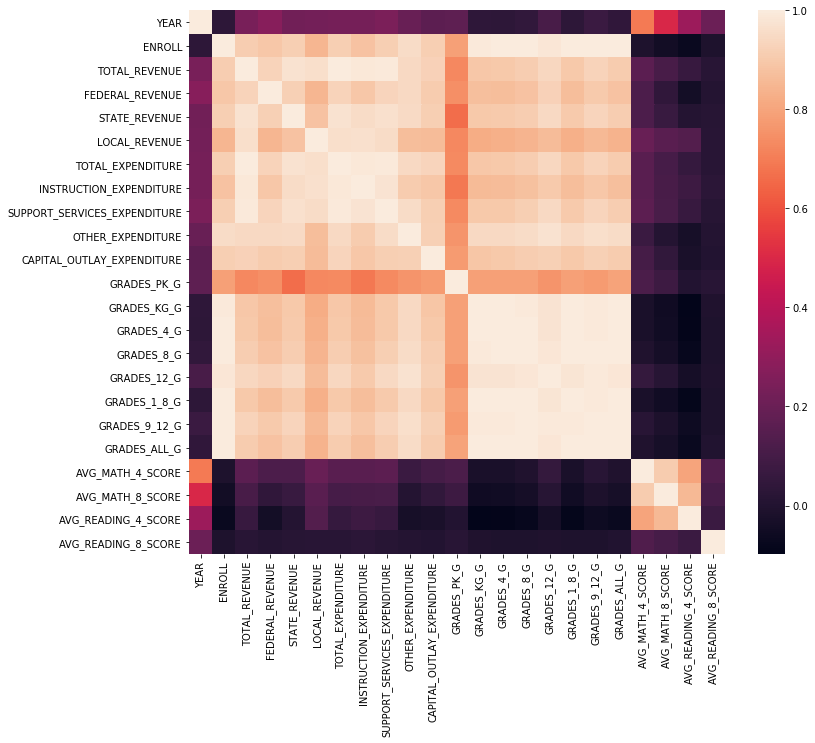

In [5]:
#plt.figure(figsize=(15,15))
corr = df.corr()
print('Number of features: ', len(corr))
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr)
print('Test scores are correlated with time.')
print('Revenues and expenditures are highly correlated with each other.')
print('School populations are highly correlated with each other.')
print('School pops and Revs/Expenditures are highly intercorrelated.')
print('Test scores are highly correlated with each other. AVG_8_READING_SCORE less so than the others.')

# PCA 

In [6]:
# PCA

from sklearn.decomposition import PCA
pca = PCA()
print(pca)

print(df.shape)

df1 = pd.get_dummies(df, columns=['STATE'])
drop_cols = ['PRIMARY_KEY', 'YEAR', 'ENROLL', \
             'TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE', \
             'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', \
             'CAPITAL_OUTLAY_EXPENDITURE', \
             'GRADES_PK_G', 'GRADES_KG_G', 'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', \
             'GRADES_1_8_G', 'GRADES_9_12_G', 'GRADES_ALL_G']
df1 = df1.drop(drop_cols, axis=1)
df1 = df1.drop('AVG_MATH_4_SCORE', axis=1)
df1 = df1.dropna(axis=0)
print(df1.shape)

# Scale features first
X = df1.loc[:,:].values
X_cols = df1.loc[:,:].columns
scaler=StandardScaler()
X_transformed = scaler.fit_transform(X)

pca.fit(X_transformed)
X_pca = pca.fit(df1).transform(X_transformed)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
(1487, 25)
(473, 83)


3 PCA components explain the variance


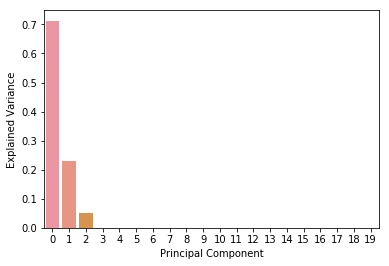

In [7]:
ax = sns.barplot(x=np.arange(20), y=pca.explained_variance_[0:20]/sum(pca.explained_variance_))
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')
print('3 PCA components explain the variance')

(473, 83)
(1487, 25)


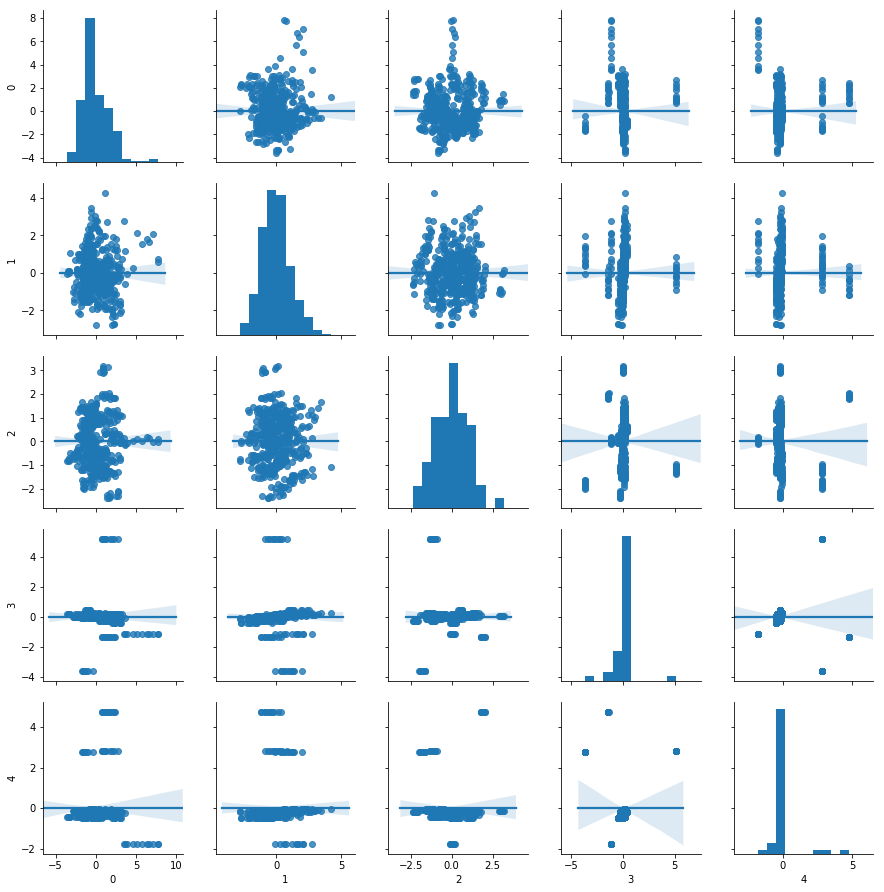

In [8]:
X_pca = pca.fit(X_transformed).transform(X_transformed)
X_pca_df = pd.DataFrame(X_pca)
print(X_pca_df.shape)
print(df.shape)
sns.pairplot(X_pca_df.iloc[:,0:5], kind='reg')

(83, 83)
Trivial: PCA Features not correlated


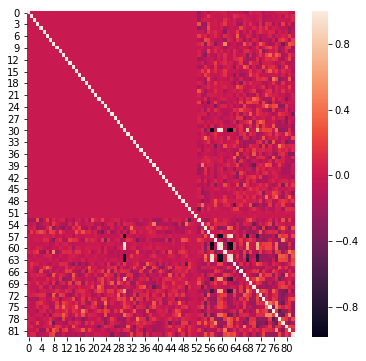

In [9]:
df_pca = pd.DataFrame(X_pca)
corr_pca = df_pca.corr()
print(corr_pca.shape)
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(corr_pca)
print('Trivial: PCA Features not correlated')

# Build Features: 

In [10]:
# Make a copy of the original data before modifying
# Use it for comparison later
df_orig = df.copy()

In [11]:
#Normalized features

df['avg_total_revenue']=df['TOTAL_REVENUE']/df['GRADES_ALL_G']
df['avg_total_expenditure'] = df['TOTAL_EXPENDITURE'] / df['GRADES_ALL_G']

df['fracn_schoolage'] = df['GRADES_ALL_G']/df['ENROLL']
df['rev_per_person'] = df['TOTAL_REVENUE'] / df['ENROLL']
df['exp_per_rev'] = df['TOTAL_EXPENDITURE'] / df['TOTAL_REVENUE']

In [12]:
#Normalize expenditures to fraction of total expenditures
expenditure_cols = ['INSTRUCTION_EXPENDITURE',
 'SUPPORT_SERVICES_EXPENDITURE',
 'OTHER_EXPENDITURE',
 'CAPITAL_OUTLAY_EXPENDITURE']

for col in expenditure_cols:
    df['fracn_exp_{}'.format(col)] = df[col] / df['TOTAL_EXPENDITURE']
    #df=df.drop(col, axis=1)
    print('fracn_exp_{}'.format(col))

fracn_exp_INSTRUCTION_EXPENDITURE
fracn_exp_SUPPORT_SERVICES_EXPENDITURE
fracn_exp_OTHER_EXPENDITURE
fracn_exp_CAPITAL_OUTLAY_EXPENDITURE


In [13]:
#Normalize revenue to fraction of total revenue
revenue_cols = ['FEDERAL_REVENUE',
 'STATE_REVENUE',
 'LOCAL_REVENUE']

for col in revenue_cols:
    df['fracn_rev_{}'.format(col)] = df[col] / df['TOTAL_REVENUE']
    #df=df.drop(col, axis=1)
    print('fracn_rev_{}'.format(col))

fracn_rev_FEDERAL_REVENUE
fracn_rev_STATE_REVENUE
fracn_rev_LOCAL_REVENUE


In [14]:
#Normalize students enrolled to fraction of enrolled population
fracn_enroll_cols = ['GRADES_PK_G', 'GRADES_KG_G',
       'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', 'GRADES_1_8_G',
       'GRADES_9_12_G']

for col in fracn_enroll_cols:
    df['fracn_enroll_{}'.format(col)] = df[col] / df['GRADES_ALL_G']
    print('fracn_enroll_{}'.format(col))
    #df = df.drop(col, axis=1) 

fracn_enroll_GRADES_PK_G
fracn_enroll_GRADES_KG_G
fracn_enroll_GRADES_4_G
fracn_enroll_GRADES_8_G
fracn_enroll_GRADES_12_G
fracn_enroll_GRADES_1_8_G
fracn_enroll_GRADES_9_12_G


In [15]:
'''
#Models want to know about previous achievement scores
#Make metrics that give more detail about the scores
df['avg_math_div_reading_4'] = df['AVG_MATH_4_SCORE'] / df['AVG_READING_4_SCORE']
df['avg_math_div_reading_8'] = df['AVG_MATH_8_SCORE'] / df['AVG_READING_8_SCORE']
df['avg_8div4_math'] = df['AVG_MATH_8_SCORE'] / df['AVG_MATH_4_SCORE']
df['avg_8div4_reading'] = df['AVG_READING_8_SCORE'] / df['AVG_READING_4_SCORE']

#Be careful not to bleed information about the result (the future) into the features
new_cols = ['avg_math_div_reading_4', 'avg_math_div_reading_8', 'avg_8div4_math', 'avg_8div4_reading']
for col in new_cols:
    df[col].fillna(method='ffill')    
kill; this will still bleed into future; this is also pulling a random test score to propagage - need to filter by stats
'''

"\n#Models want to know about previous achievement scores\n#Make metrics that give more detail about the scores\ndf['avg_math_div_reading_4'] = df['AVG_MATH_4_SCORE'] / df['AVG_READING_4_SCORE']\ndf['avg_math_div_reading_8'] = df['AVG_MATH_8_SCORE'] / df['AVG_READING_8_SCORE']\ndf['avg_8div4_math'] = df['AVG_MATH_8_SCORE'] / df['AVG_MATH_4_SCORE']\ndf['avg_8div4_reading'] = df['AVG_READING_8_SCORE'] / df['AVG_READING_4_SCORE']\n\n#Be careful not to bleed information about the result (the future) into the features\nnew_cols = ['avg_math_div_reading_4', 'avg_math_div_reading_8', 'avg_8div4_math', 'avg_8div4_reading']\nfor col in new_cols:\n    df[col].fillna(method='ffill')    \nkill; this will still bleed into future; this is also pulling a random test score to propagage - need to filter by stats\n"

In [16]:
#Models want to know about drop-out rate
df['fracn_GRADES_12div8_G'] = np.zeros(len(df))
#Divide take ratio GRADES_12_G(YEAR)/GRADES_8_G(YEAR-4)
for state in set(df['STATE'].tolist()):
    for year in set(df['YEAR'].tolist()):
        key= "{}_{}".format(year, state)
        lag_year = year-4
        lag_key= "{}_{}".format(lag_year, state)
        if np.any(df['PRIMARY_KEY']==lag_key):
            df.loc[df['PRIMARY_KEY']==key, ['fracn_GRADES_12div8_G']]= np.divide( \
                df[df['PRIMARY_KEY']==key]['GRADES_12_G'], np.median(df[df['PRIMARY_KEY']==lag_key]['GRADES_8_G']))

/Users/daviderickson/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


In [17]:
# Function to return most recent test result
def most_recent_test(cur_yr, state, df, new_cols):
    most_recent_value= pd.Series(data=None, index=new_cols)
    most_recent_value2= pd.Series(data=None, index=new_cols)
    df_scratch= df # .copy()
    df_scratch= df_scratch[df_scratch['STATE']==state]
    df_scratch= df_scratch[df_scratch['YEAR']<cur_yr]
    df_scratch.sort_values(by='YEAR')
    
    for new_col in new_cols:
        df_scratch2= df_scratch[df_scratch[new_col].notna()]
        if df_scratch2.notna().any().any(): 
            most_recent_value[new_col]= df_scratch2[new_col].iloc[-1]
            if np.sum(df_scratch2[new_col].notna()) > 1:
                most_recent_value2[new_col]= df_scratch2[new_col].iloc[-2]
        else:
            most_recent_value[new_col]= np.nan #Should handle these cases better
    # for col in most_recent_value.columns:
    labels = ['recent_' + col for col in new_cols]
    most_recent_value.set_axis(labels, axis=0, inplace=True)
    most_recent_value2.set_axis(labels, axis=0, inplace=True)
    return most_recent_value, most_recent_value2

In [18]:
# Add recent_ features
cols_add_recent = ['ENROLL', 'TOTAL_REVENUE', 'GRADES_ALL_G', 'GRADES_4_G', \
                   'AVG_MATH_4_SCORE', 'AVG_MATH_8_SCORE', 'AVG_READING_4_SCORE', 'AVG_READING_8_SCORE', \
                   'fracn_rev_FEDERAL_REVENUE','fracn_enroll_GRADES_PK_G', 'fracn_enroll_GRADES_KG_G', \
                   'fracn_enroll_GRADES_4_G', 'fracn_enroll_GRADES_8_G','fracn_enroll_GRADES_12_G', \
                   'fracn_enroll_GRADES_1_8_G', 'fracn_enroll_GRADES_9_12_G', 'avg_total_revenue', \
                   'avg_total_expenditure', 'fracn_schoolage', 'rev_per_person', \
                   'exp_per_rev', 'fracn_GRADES_12div8_G']

for index, data in df.iterrows(): 
    recent_test, recent_test2= most_recent_test(cur_yr=data['YEAR'], state=data['STATE'], df=df, new_cols=cols_add_recent)
    for col in recent_test.index.tolist(): 
        df.loc[index, col] = recent_test[col]
        df.loc[index, col+'2'] = recent_test2[col]
print('recent_ features added:')
print(cols_add_recent)


recent_ features added:
['ENROLL', 'TOTAL_REVENUE', 'GRADES_ALL_G', 'GRADES_4_G', 'AVG_MATH_4_SCORE', 'AVG_MATH_8_SCORE', 'AVG_READING_4_SCORE', 'AVG_READING_8_SCORE', 'fracn_rev_FEDERAL_REVENUE', 'fracn_enroll_GRADES_PK_G', 'fracn_enroll_GRADES_KG_G', 'fracn_enroll_GRADES_4_G', 'fracn_enroll_GRADES_8_G', 'fracn_enroll_GRADES_12_G', 'fracn_enroll_GRADES_1_8_G', 'fracn_enroll_GRADES_9_12_G', 'avg_total_revenue', 'avg_total_expenditure', 'fracn_schoolage', 'rev_per_person', 'exp_per_rev', 'fracn_GRADES_12div8_G']


In [19]:
print('Adding delta_ features')

delta_cols = ['ENROLL', 'TOTAL_REVENUE', 'GRADES_ALL_G', 'GRADES_4_G', \
            # This would bleed info from future
              # Would need delta_ of previous timepoint to get delta_ info for _SCORE
            # 'AVG_MATH_4_SCORE', 'AVG_MATH_8_SCORE', 'AVG_READING_4_SCORE', 'AVG_READING_8_SCORE', \
           'fracn_rev_FEDERAL_REVENUE','fracn_enroll_GRADES_PK_G', 'fracn_enroll_GRADES_KG_G', \
           'fracn_enroll_GRADES_4_G', 'fracn_enroll_GRADES_8_G','fracn_enroll_GRADES_12_G', \
           'fracn_enroll_GRADES_1_8_G', 'fracn_enroll_GRADES_9_12_G', 'avg_total_revenue', \
           'avg_total_expenditure', 'fracn_schoolage', 'rev_per_person', \
           'exp_per_rev', 'fracn_GRADES_12div8_G']

for col in delta_cols:
    df['delta_{}'.format(col)] = df[col] - df['recent_{}'.format(col)]
    #df=df.drop(col, axis=1)
    print('delta_{}'.format(col))

print('delta_ features added')

Adding delta_ features
delta_ENROLL
delta_TOTAL_REVENUE
delta_GRADES_ALL_G
delta_GRADES_4_G
delta_fracn_rev_FEDERAL_REVENUE
delta_fracn_enroll_GRADES_PK_G
delta_fracn_enroll_GRADES_KG_G
delta_fracn_enroll_GRADES_4_G
delta_fracn_enroll_GRADES_8_G
delta_fracn_enroll_GRADES_12_G
delta_fracn_enroll_GRADES_1_8_G
delta_fracn_enroll_GRADES_9_12_G
delta_avg_total_revenue
delta_avg_total_expenditure
delta_fracn_schoolage
delta_rev_per_person
delta_exp_per_rev
delta_fracn_GRADES_12div8_G
delta_ features added


In [20]:
df.describe()

,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,...,delta_fracn_enroll_GRADES_8_G,delta_fracn_enroll_GRADES_12_G,delta_fracn_enroll_GRADES_1_8_G,delta_fracn_enroll_GRADES_9_12_G,delta_avg_total_revenue,delta_avg_total_expenditure,delta_fracn_schoolage,delta_rev_per_person,delta_exp_per_rev,delta_fracn_GRADES_12div8_G
count,1487.000000,1.224000e+03,1.275000e+03,1.275000e+03,1.275000e+03,1.275000e+03,1.275000e+03,1.275000e+03,1.275000e+03,1.224000e+03,...,1245.000000,1245.000000,1245.000000,1245.000000,1163.000000,1163.000000,1113.000000,1173.000000,1224.000000,1286.000000
mean,2004.419637,9.175416e+05,9.102045e+06,7.677799e+05,4.223743e+06,4.110522e+06,9.206242e+06,4.768010e+06,2.682587e+06,4.299509e+05,...,-0.000014,0.000778,-0.002745,0.001845,0.369862,0.361695,-0.001093,0.371079,-0.000836,0.045969
std,7.402309,1.066514e+06,1.175962e+07,1.146992e+06,5.549735e+06,5.489562e+06,1.199279e+07,6.300569e+06,3.357214e+06,5.347893e+05,...,0.001913,0.002891,0.007834,0.008405,0.603082,0.600104,0.045645,0.551944,0.032612,0.190875
min,1992.000000,4.386600e+04,4.656500e+05,3.102000e+04,0.000000e+00,2.209300e+04,4.816650e+05,2.655490e+05,1.399630e+05,1.154100e+04,...,-0.009597,-0.015024,-0.062036,-0.066128,-6.714628,-6.653822,-0.847495,-3.508257,-0.196380,-0.830664
25%,1998.000000,2.645145e+05,2.189504e+06,1.899575e+05,1.165776e+06,7.151210e+05,2.170404e+06,1.171336e+06,6.380760e+05,1.034492e+05,...,-0.001057,-0.000606,-0.004944,-0.001557,0.158836,0.125562,-0.003269,0.177580,-0.017519,-0.001225
50%,2004.000000,6.499335e+05,5.085826e+06,4.035480e+05,2.537754e+06,2.058996e+06,5.242672e+06,2.658253e+06,1.525471e+06,2.717040e+05,...,-0.000090,0.000510,-0.001926,0.001160,0.351789,0.349207,0.000993,0.339833,-0.000538,0.003621
75%,2011.000000,1.010532e+06,1.084516e+07,8.279320e+05,5.055548e+06,4.755293e+06,1.074420e+07,5.561959e+06,3.222924e+06,5.172222e+05,...,0.000942,0.001708,0.000817,0.003999,0.576301,0.583844,0.005616,0.541248,0.015915,0.017219
max,2017.000000,6.307022e+06,8.921726e+07,9.990221e+06,5.090457e+07,3.610526e+07,8.532013e+07,4.396452e+07,2.605802e+07,3.995951e+06,...,0.016297,0.029455,0.039099,0.078879,5.820202,7.198079,0.347254,9.194547,0.177213,1.010082


(105, 105)


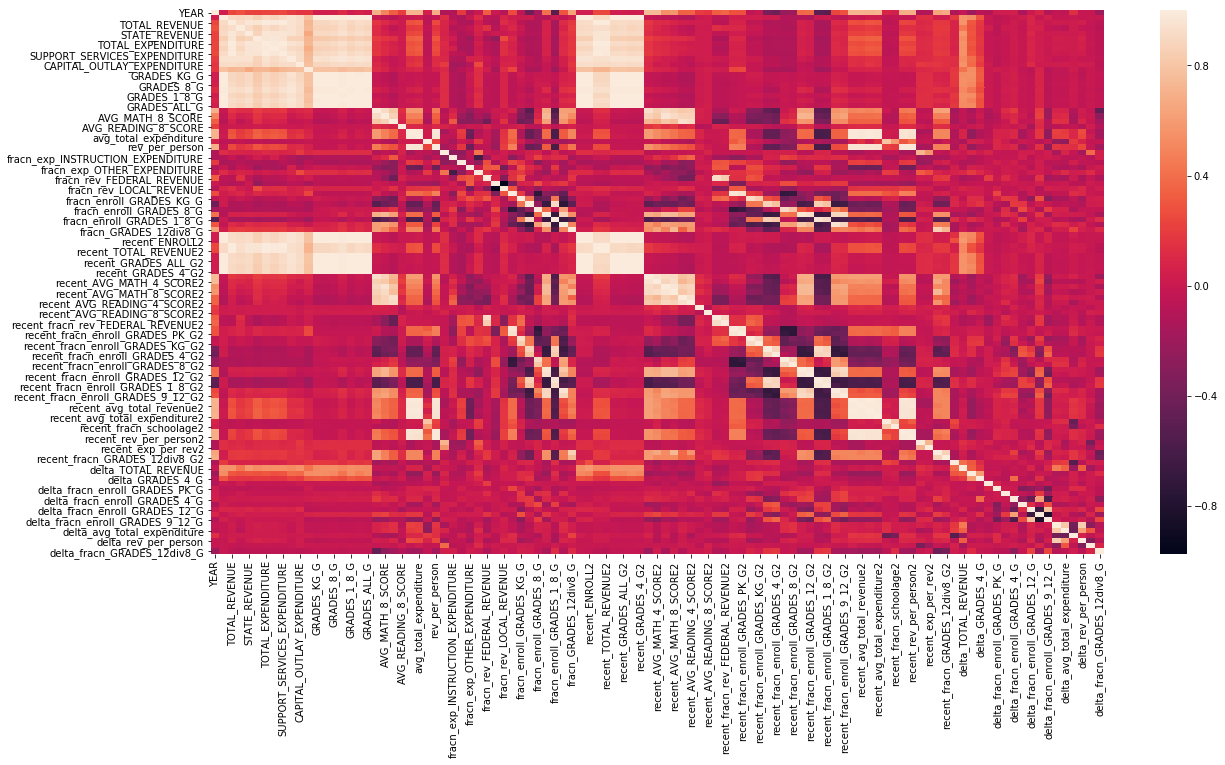

In [21]:
#plt.figure(figsize=(15,15))
corr = df.corr()
print(corr.shape)
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corr)

# PCA

In [22]:
# PCA

from sklearn.decomposition import PCA
pca = PCA()
print(pca)

print(df.shape)

df1 = pd.get_dummies(df, columns=['STATE'])
drop_cols = ['PRIMARY_KEY', 'YEAR', 'ENROLL', \
             'TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE', \
             'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', \
             'CAPITAL_OUTLAY_EXPENDITURE', \
             'GRADES_PK_G', 'GRADES_KG_G', 'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', \
             'GRADES_1_8_G', 'GRADES_9_12_G', 'GRADES_ALL_G']
df1 = df1.drop(drop_cols, axis=1)
df1 = df1.drop('AVG_MATH_4_SCORE', axis=1)
df1 = df1.dropna(axis=0)
print(df1.shape)

# Scale features first
X = df1.loc[:,:].values
X_cols = df1.loc[:,:].columns
scaler=StandardScaler()
X_transformed = scaler.fit_transform(X)

pca.fit(X_transformed)
X_pca = pca.fit(df1).transform(X_transformed)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
(1487, 107)
(328, 165)


Text(0, 0.5, 'Explained Variance')

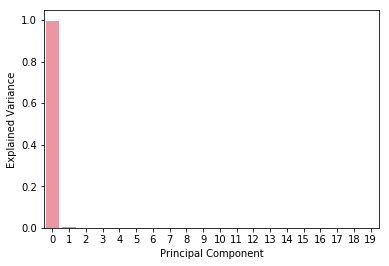

In [23]:
ax = sns.barplot(x=np.arange(20), y=pca.explained_variance_[0:20]/sum(pca.explained_variance_))
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')

(328, 165)
(1487, 107)


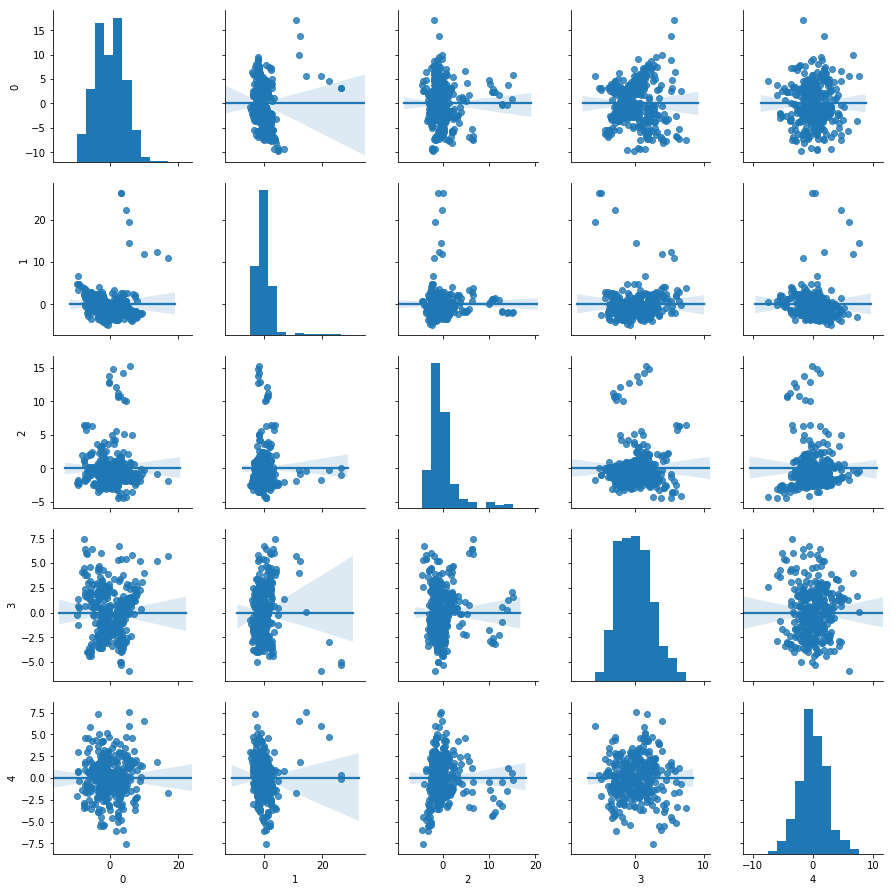

In [24]:
X_pca = pca.fit(X_transformed).transform(X_transformed)
X_pca_df = pd.DataFrame(X_pca)
print(X_pca_df.shape)
print(df.shape)
sns.pairplot(X_pca_df.iloc[:,0:5], kind='reg')

# Explore Data

<Figure size 432x288 with 0 Axes>

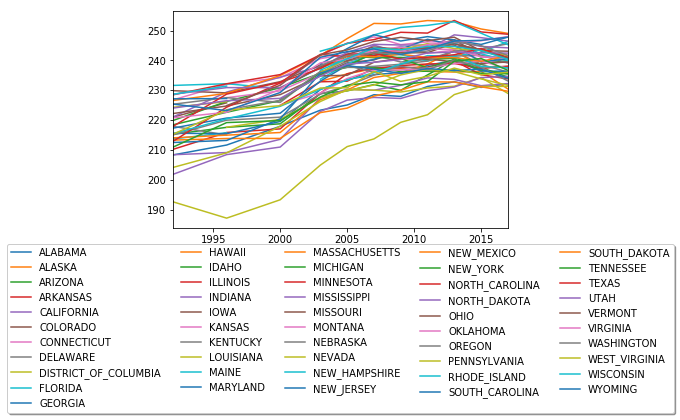

In [25]:
plt.figure()
df.pivot_table('AVG_MATH_4_SCORE', index='YEAR', columns='STATE', aggfunc='median').plot()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

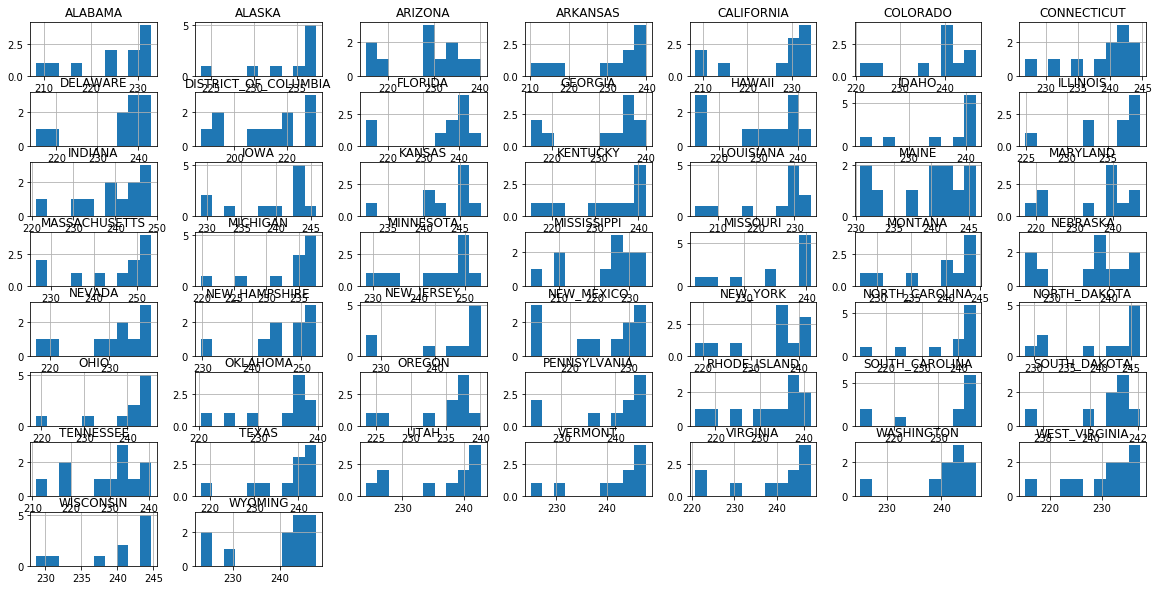

In [26]:
df.pivot_table('AVG_MATH_4_SCORE', index='YEAR', columns='STATE', aggfunc='median').hist(figsize=(20,10));

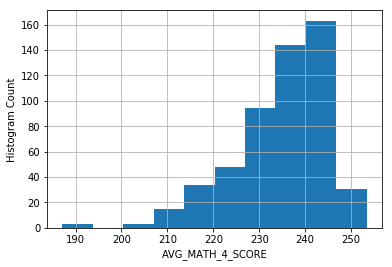

Text(0, 0.5, 'Cumulative Histogram')

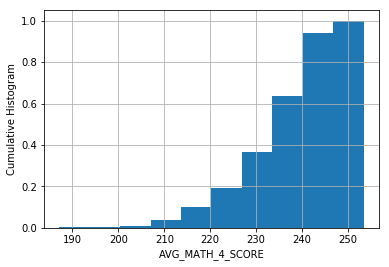

In [27]:
df['AVG_MATH_4_SCORE'].dropna().hist()
plt.xlabel('AVG_MATH_4_SCORE')
plt.ylabel('Histogram Count')
plt.show()
df['AVG_MATH_4_SCORE'].dropna().hist(density=True, cumulative=True)
plt.xlabel('AVG_MATH_4_SCORE')
plt.ylabel('Cumulative Histogram')

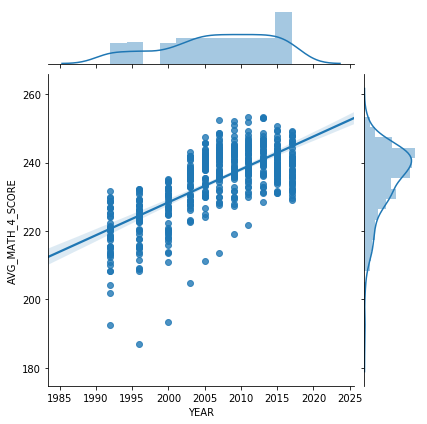

In [28]:
sns.jointplot("YEAR", "AVG_MATH_4_SCORE", data=df, kind="reg")

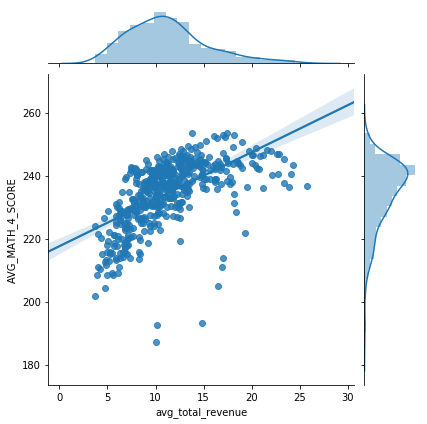

In [29]:
sns.jointplot("avg_total_revenue", "AVG_MATH_4_SCORE", data=df, kind="reg")

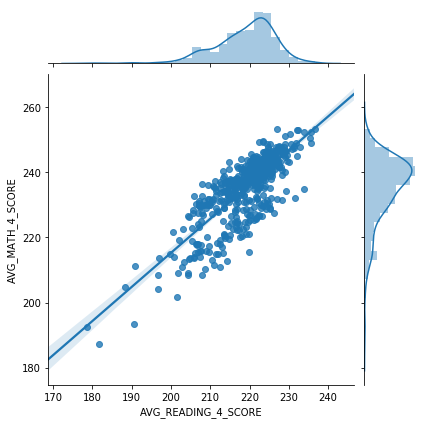

In [30]:
sns.jointplot("AVG_READING_4_SCORE", "AVG_MATH_4_SCORE", data=df, kind="reg")

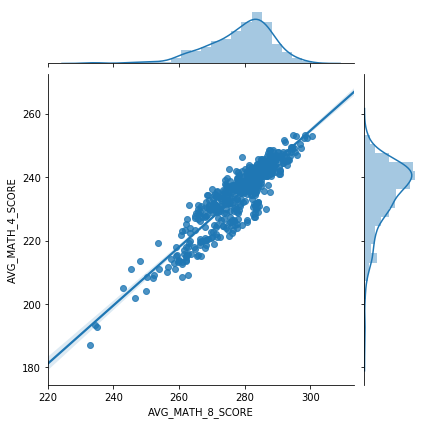

In [31]:
sns.jointplot("AVG_MATH_8_SCORE", "AVG_MATH_4_SCORE", data=df, kind="reg")

# Random Forest
## Learning Curve

In [32]:
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error

num_splits=20
score_cols = ['model_score', 'mse', 'expalined_variance', 'mae']

df1=df.drop(['PRIMARY_KEY','AVG_MATH_8_SCORE','AVG_READING_4_SCORE','AVG_READING_8_SCORE','ENROLL'],axis=1)
df1 = df1.dropna()
df1 = pd.get_dummies(df1, columns=['STATE'])

y=df1.loc[:,'AVG_MATH_4_SCORE'].values
X=df1.drop(['AVG_MATH_4_SCORE'],axis=1).loc[:,:].values
X_cols=df1.drop(['AVG_MATH_4_SCORE'],axis=1).columns

ts_cv = TimeSeriesSplit(n_splits=num_splits)
rf_model = RandomForestRegressor(n_estimators=100, n_jobs=-1)

index=0
train_score = pd.DataFrame(data=np.zeros((num_splits, len(score_cols))), columns=score_cols)
test_score = pd.DataFrame(data=np.zeros((num_splits, len(score_cols))), columns=score_cols)

for train_index, test_index in ts_cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]   
    
    rf_model.fit(X_train, y_train) 
    y_train_fit = rf_model.predict(X_train)
    Y_rf=rf_model.predict(X_test)
    #Train score
    train_score.loc[index] = rf_model.score(X_train,y_train), mean_squared_error(y_train, y_train_fit), \
        explained_variance_score(y_train, y_train_fit), mean_absolute_error(y_train, y_train_fit)
    #Test score
    test_score.loc[index] = rf_model.score(X_test,y_test), mean_squared_error(y_test, Y_rf), \
        explained_variance_score(y_test, Y_rf), mean_absolute_error(y_test, Y_rf)
    index+=1
index_list=np.arange(index)

In [33]:
test_score.describe()

,model_score,mse,expalined_variance,mae
count,20.000000,20.000000,20.000000,20.000000
mean,0.730641,7.776956,0.788293,2.101753
std,0.228615,5.836450,0.140864,0.781809
min,-0.046431,3.048766,0.398183,1.402984
25%,0.665481,4.145719,0.734781,1.613973
50%,0.804535,5.636629,0.826322,1.886343
75%,0.857001,8.593828,0.881922,2.168132
max,0.945546,25.458212,0.953634,4.320516


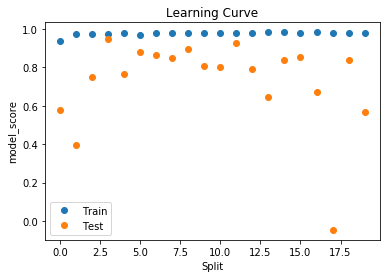

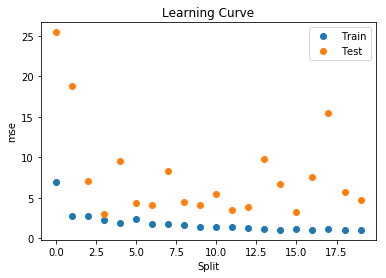

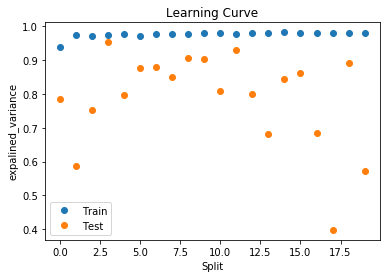

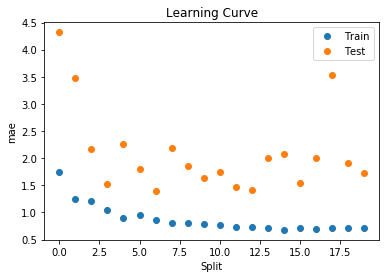

In [34]:
for col in score_cols:
    plt.figure()
    plt.title('Learning Curve')
    plt.plot(index_list,train_score[col],'o', label="Train")
    plt.plot(index_list,test_score[col],'o', label="Test")
    plt.xlabel("Split")
    plt.ylabel(col)
    plt.legend(loc="best")
    plt.show()

## Validation Curve

In [35]:
model=RandomForestRegressor()

num_splits=20
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

"""
param_search = [
  {'n_estimators': [1, 10, 20, 100]}
]
gsrch_rf_model=GridSearchCV(estimator=model, param_grid=param_search, cv=ts_cv, n_jobs=-1)
gsrch_rf_model.fit(X,y)
"""

#train_sizes, train_scores, test_scores = \
#    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=10), cv=ts_cv, n_jobs=-1)

param_range=[4,5,6,8,10, 13,20,30,40,50,60,100,500]
train_scores_vc, test_scores_vc = \
    validation_curve(estimator=model, X=X, y=y, param_name="n_estimators", param_range=param_range, \
                     cv=ts_cv, n_jobs=-1, scoring='neg_mean_squared_error')

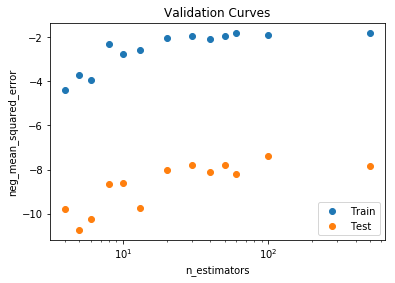

In [36]:
train_scores_mean = np.mean(train_scores_vc, axis=1)
train_scores_std = np.std(train_scores_vc, axis=1)
test_scores_mean = np.mean(test_scores_vc, axis=1)
test_scores_std = np.std(test_scores_vc, axis=1)

plt.figure()
plt.plot(param_range,train_scores_mean,'o',label="Train")
plt.plot(param_range,test_scores_mean,'o',label="Test")
plt.xlabel("n_estimators")
plt.ylabel("neg_mean_squared_error")
plt.title("Validation Curves")
plt.legend(loc="best")
plt.xscale('log')

In [37]:
print('Compare to same Validation curves using only original features')

df1=df_orig.drop(['PRIMARY_KEY','AVG_MATH_8_SCORE','AVG_READING_4_SCORE','AVG_READING_8_SCORE','ENROLL'],axis=1)
df1 = df1.dropna()
df1 = pd.get_dummies(df1, columns=['STATE'])

y=df1.loc[:,'AVG_MATH_4_SCORE'].values
X=df1.drop(['AVG_MATH_4_SCORE'],axis=1).loc[:,:].values
X_cols=df1.drop(['AVG_MATH_4_SCORE'],axis=1).columns

model=RandomForestRegressor()
num_splits=20
ts_cv=TimeSeriesSplit(n_splits=num_splits)
param_range=[4,5,6,8,10, 13,20,30,40,50,60,100,500]

train_scores_vc, test_scores_vc = \
    validation_curve(estimator=model, X=X, y=y, param_name="n_estimators", param_range=param_range, \
                     cv=ts_cv, n_jobs=-1, scoring='neg_mean_squared_error')

Compare to same Validation curves using only original features


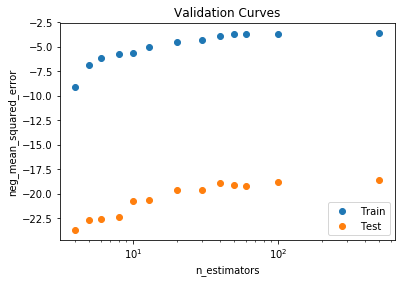

In [38]:
train_scores_mean = np.mean(train_scores_vc, axis=1)
train_scores_std = np.std(train_scores_vc, axis=1)
test_scores_mean = np.mean(test_scores_vc, axis=1)
test_scores_std = np.std(test_scores_vc, axis=1)

plt.figure()
plt.plot(param_range,train_scores_mean,'o',label="Train")
plt.plot(param_range,test_scores_mean,'o',label="Test")
plt.xlabel("n_estimators")
plt.ylabel("neg_mean_squared_error")
plt.title("Validation Curves")
plt.legend(loc="best")
plt.xscale('log')

Compare to same Validation curves using only original features


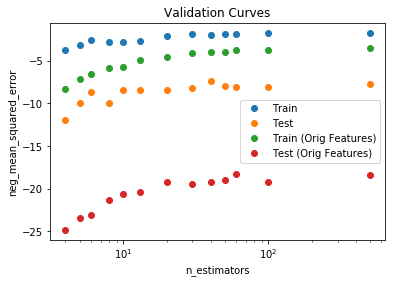

In [39]:
model=RandomForestRegressor()

df1=df.drop(['PRIMARY_KEY','AVG_MATH_8_SCORE','AVG_READING_4_SCORE','AVG_READING_8_SCORE','ENROLL'],axis=1)
df1 = df1.dropna()
df1 = pd.get_dummies(df1, columns=['STATE'])

y=df1.loc[:,'AVG_MATH_4_SCORE'].values
X=df1.drop(['AVG_MATH_4_SCORE'],axis=1).loc[:,:].values
X_cols=df1.drop(['AVG_MATH_4_SCORE'],axis=1).columns

num_splits=20
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

param_range=[4,5,6,8,10, 13,20,30,40,50,60,100,500]
train_scores_vc, test_scores_vc = \
    validation_curve(estimator=model, X=X, y=y, param_name="n_estimators", param_range=param_range, \
                     cv=ts_cv, n_jobs=-1, scoring='neg_mean_squared_error')

train_scores_mean = np.mean(train_scores_vc, axis=1)
train_scores_std = np.std(train_scores_vc, axis=1)
test_scores_mean = np.mean(test_scores_vc, axis=1)
test_scores_std = np.std(test_scores_vc, axis=1)

plt.figure()
plt.plot(param_range,train_scores_mean,'o',label="Train")
plt.plot(param_range,test_scores_mean,'o',label="Test")
plt.xlabel("n_estimators")
plt.ylabel("neg_mean_squared_error")
plt.title("Validation Curves")
plt.legend(loc="best")
plt.xscale('log')


print('Compare to same Validation curves using only original features')

df1=df_orig.drop(['PRIMARY_KEY','AVG_MATH_8_SCORE','AVG_READING_4_SCORE','AVG_READING_8_SCORE','ENROLL'],axis=1)
df1 = df1.dropna()
df1 = pd.get_dummies(df1, columns=['STATE'])

y=df1.loc[:,'AVG_MATH_4_SCORE'].values
X=df1.drop(['AVG_MATH_4_SCORE'],axis=1).loc[:,:].values
X_cols=df1.drop(['AVG_MATH_4_SCORE'],axis=1).columns

model=RandomForestRegressor()
num_splits=20
ts_cv=TimeSeriesSplit(n_splits=num_splits)
param_range=[4,5,6,8,10, 13,20,30,40,50,60,100,500]

train_scores_vc, test_scores_vc = \
    validation_curve(estimator=model, X=X, y=y, param_name="n_estimators", param_range=param_range, \
                     cv=ts_cv, n_jobs=-1, scoring='neg_mean_squared_error')

train_scores_mean = np.mean(train_scores_vc, axis=1)
train_scores_std = np.std(train_scores_vc, axis=1)
test_scores_mean = np.mean(test_scores_vc, axis=1)
test_scores_std = np.std(test_scores_vc, axis=1)

# plt.figure()
plt.plot(param_range,train_scores_mean,'o',label="Train (Orig Features)")
plt.plot(param_range,test_scores_mean,'o',label="Test (Orig Features)")
plt.xlabel("n_estimators")
plt.ylabel("neg_mean_squared_error")
plt.title("Validation Curves")
plt.legend(loc="best")
plt.xscale('log')
plt.show()

## RF Evaluation

In [40]:
model=RandomForestRegressor(n_estimators=20)

num_splits=20
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

df1=df.drop(['PRIMARY_KEY','AVG_MATH_8_SCORE','AVG_READING_4_SCORE','AVG_READING_8_SCORE','ENROLL'],axis=1)
df1 = df1.dropna()
df1 = pd.get_dummies(df1, columns=['STATE'])
y=df1.loc[:,'AVG_MATH_4_SCORE'].values
X=df1.drop(['AVG_MATH_4_SCORE'],axis=1).loc[:,:].values
X_cols=df1.drop(['AVG_MATH_4_SCORE'],axis=1).columns

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=num_splits), 
                   cv=ts_cv, n_jobs=-1, scoring='neg_mean_squared_error')

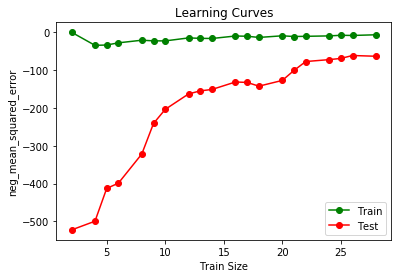

In [41]:
plt.figure()
plt.plot(train_sizes, train_scores.mean(1), 'o-', color="g",
         label="Train")
plt.plot(train_sizes, test_scores.mean(1), 'o-', color="r",
         label="Test")
plt.xlabel("Train Size")
plt.ylabel("neg_mean_squared_error")
plt.title("Learning Curves")
plt.legend(loc="best")

In [42]:
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X, y)  

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

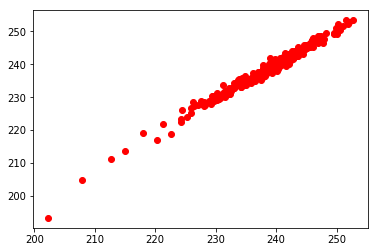

In [43]:
Y_rf=rf_model.predict(X)
plt.plot(Y_rf, y, 'ro')
plt.show()

In [44]:
feature_importances_rf = pd.DataFrame(rf_model.feature_importances_, index = df1.drop(['AVG_MATH_4_SCORE'],axis=1).columns, columns=['importance']).sort_values('importance',ascending=False)
feature_importances_rf.head(10)

,importance
recent_AVG_MATH_4_SCORE,0.571269
recent_AVG_MATH_8_SCORE,0.183704
recent_AVG_MATH_8_SCORE2,0.033473
recent_AVG_READING_4_SCORE2,0.024846
recent_AVG_READING_4_SCORE,0.021997
recent_AVG_MATH_4_SCORE2,0.020325
fracn_exp_SUPPORT_SERVICES_EXPENDITURE,0.012168
YEAR,0.005569
OTHER_EXPENDITURE,0.005254
recent_fracn_enroll_GRADES_9_12_G2,0.004748


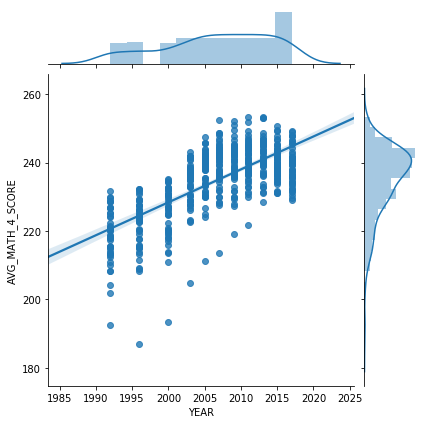

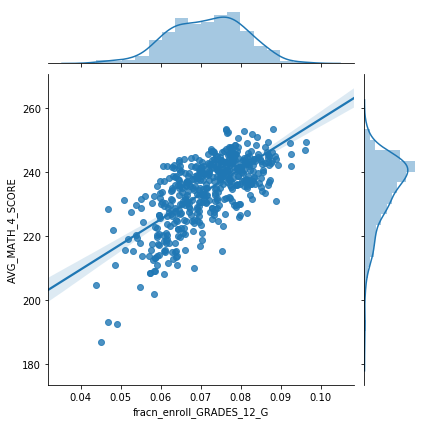

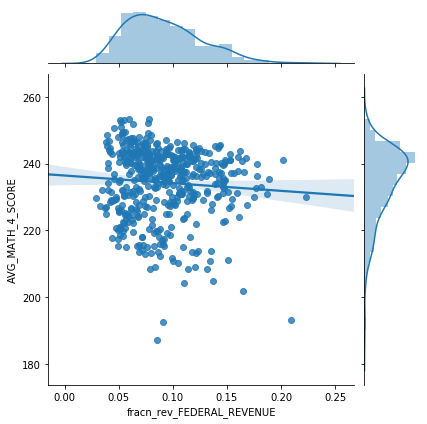

In [45]:
sns.jointplot(x='YEAR', y='AVG_MATH_4_SCORE', data=df, kind='reg')
sns.jointplot(x='fracn_enroll_GRADES_12_G', y='AVG_MATH_4_SCORE', data=df, kind='reg')
sns.jointplot(x='fracn_rev_FEDERAL_REVENUE', y='AVG_MATH_4_SCORE', data=df, kind='reg')

# Lasso
## Validation Curve

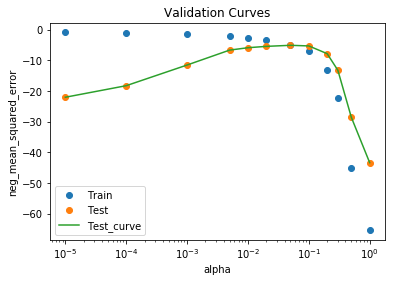

In [46]:
model=linear_model.Lasso(normalize=True)
param_search = [
  {'alpha': [0.00001,0.0001,0.001,0.01,0.1,1]}
 ]

num_splits=20
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

#gsrch_rf_model=GridSearchCV(estimator=model, param_grid=param_search, cv=ts_cv, n_jobs=-1)
#gsrch_rf_model.fit(X,y)

#train_sizes, train_scores, test_scores = \
#    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=10), cv=ts_cv, n_jobs=-1)

param_range=[0.00001,0.0001,0.001,0.005,0.01,0.02,0.05,0.1,0.2,0.3,0.5,1]
train_scores_vc, test_scores_vc = \
    validation_curve(estimator=model, X=X, y=y, param_name="alpha", param_range=param_range, 
                     cv=ts_cv, n_jobs=-1, scoring='neg_mean_squared_error')

train_scores_mean = np.mean(train_scores_vc, axis=1)
train_scores_std = np.std(train_scores_vc, axis=1)
test_scores_mean = np.mean(test_scores_vc, axis=1)
test_scores_std = np.std(test_scores_vc, axis=1)

plt.figure()
plt.semilogx(param_range,train_scores_mean,'o',label="Train")
plt.semilogx(param_range,test_scores_mean,'o',label="Test")
plt.semilogx(param_range,test_scores_mean,label="Test_curve")
plt.xlabel("alpha")
plt.ylabel("neg_mean_squared_error")
plt.title("Validation Curves")
plt.legend(loc="best")

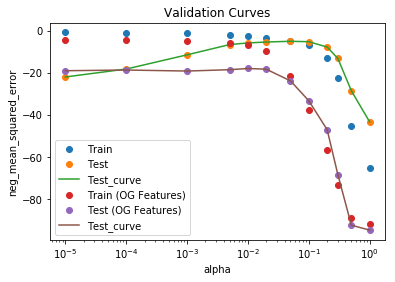

In [47]:
model=linear_model.Lasso(normalize=True)
df1=df.drop(['PRIMARY_KEY','AVG_MATH_8_SCORE','AVG_READING_4_SCORE','AVG_READING_8_SCORE','ENROLL'],axis=1)
df1 = df1.dropna()
df1 = pd.get_dummies(df1, columns=['STATE'])
y=df1.loc[:,'AVG_MATH_4_SCORE'].values
X=df1.drop(['AVG_MATH_4_SCORE'],axis=1).loc[:,:].values
X_cols=df1.drop(['AVG_MATH_4_SCORE'],axis=1).columns
num_splits=20
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

param_range=[0.00001,0.0001,0.001,0.005,0.01,0.02,0.05,0.1,0.2,0.3,0.5,1]
train_scores_vc, test_scores_vc = \
    validation_curve(estimator=model, X=X, y=y, param_name="alpha", param_range=param_range, 
                     cv=ts_cv, n_jobs=-1, scoring='neg_mean_squared_error')

train_scores_mean = np.mean(train_scores_vc, axis=1)
train_scores_std = np.std(train_scores_vc, axis=1)
test_scores_mean = np.mean(test_scores_vc, axis=1)
test_scores_std = np.std(test_scores_vc, axis=1)

plt.figure()
plt.semilogx(param_range,train_scores_mean,'o',label="Train")
plt.semilogx(param_range,test_scores_mean,'o',label="Test")
plt.semilogx(param_range,test_scores_mean,label="Test_curve")
plt.xlabel("alpha")
plt.ylabel("neg_mean_squared_error")
plt.title("Validation Curves")
plt.legend(loc="best")

model=linear_model.Lasso(normalize=True)
df1=df_orig.drop(['PRIMARY_KEY','AVG_MATH_8_SCORE','AVG_READING_4_SCORE','AVG_READING_8_SCORE','ENROLL'],axis=1)
df1 = df1.dropna()
df1 = pd.get_dummies(df1, columns=['STATE'])
y=df1.loc[:,'AVG_MATH_4_SCORE'].values
X=df1.drop(['AVG_MATH_4_SCORE'],axis=1).loc[:,:].values
X_cols=df1.drop(['AVG_MATH_4_SCORE'],axis=1).columns
num_splits=20
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

param_range=[0.00001,0.0001,0.001,0.005,0.01,0.02,0.05,0.1,0.2,0.3,0.5,1]
train_scores_vc, test_scores_vc = \
    validation_curve(estimator=model, X=X, y=y, param_name="alpha", param_range=param_range, 
                     cv=ts_cv, n_jobs=-1, scoring='neg_mean_squared_error')

train_scores_mean = np.mean(train_scores_vc, axis=1)
train_scores_std = np.std(train_scores_vc, axis=1)
test_scores_mean = np.mean(test_scores_vc, axis=1)
test_scores_std = np.std(test_scores_vc, axis=1)

plt.semilogx(param_range,train_scores_mean,'o',label="Train (OG Features)")
plt.semilogx(param_range,test_scores_mean,'o',label="Test (OG Features)")
plt.semilogx(param_range,test_scores_mean,label="Test_curve")
plt.xlabel("alpha")
plt.ylabel("neg_mean_squared_error")
plt.title("Validation Curves")
plt.legend(loc="best")

In [48]:
lasso_best_alpha = 0.05

## Learning Curve

(20,) (20, 20) (20, 20)


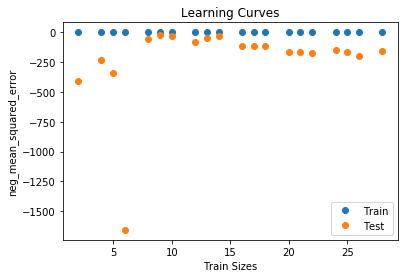

In [49]:
model=linear_model.Lasso(alpha=lasso_best_alpha, normalize=True)

df1=df.drop(['PRIMARY_KEY','AVG_MATH_8_SCORE','AVG_READING_4_SCORE','AVG_READING_8_SCORE','ENROLL'],axis=1)
df1 = df1.dropna()
df1 = pd.get_dummies(df1, columns=['STATE'])
y=df1.loc[:,'AVG_MATH_4_SCORE'].values
X=df1.drop(['AVG_MATH_4_SCORE'],axis=1).loc[:,:].values
X_cols=df1.drop(['AVG_MATH_4_SCORE'],axis=1).columns

num_splits=20
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=num_splits), 
                   cv=ts_cv, n_jobs=-1, scoring='neg_mean_squared_error')

print(train_sizes.shape,train_scores.shape, test_scores.shape)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes,train_scores_mean,'o',label="Train")
plt.plot(train_sizes,test_scores_mean,'o',label="Test")
plt.xlabel("Train Sizes")
plt.ylabel("neg_mean_squared_error")
plt.title("Learning Curves")
plt.legend(loc="best")

In [50]:
"""Plot test data fit"""

'Plot test data fit'

Text(0, 0.5, 'y')

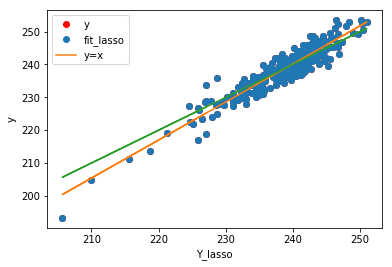

In [51]:

lasso_model=linear_model.Lasso(alpha=lasso_best_alpha, normalize=True)
lasso_model.fit(X, y)  
Y_lasso=lasso_model.predict(X)
plt.plot(Y_lasso, y, 'ro')

# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(Y_lasso,y)
line = slope*Y_lasso+intercept

plt.plot(Y_lasso,y,'o',Y_lasso,line,Y_lasso,Y_lasso)
plt.legend(("y","fit_lasso","y=x"),loc='best')
plt.xlabel("Y_lasso")
plt.ylabel("y")

In [52]:
lasso_coef_ = lasso_model.coef_
print(X_cols.shape)
#print(X_cols)
print(lasso_coef_.shape)
print(np.round(lasso_coef_))
#print(lasso_coef_)
X_cols[np.abs(lasso_coef_)>10]

sorted(zip(lasso_coef_.round(), X_cols))

(151,)
(151,)
[-0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. -0.  0.  0.  0. -0. -0. -0. -0.  0. -0. -0. -0. -0.  0.  0. -0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0.  0.  0.  0.  0. -0. -0.  0.  0.  0.  0.
  0.  0. -0.  0.  0.  0. -0. -0.  0.  0.  0.  0.  0. -0. -0. -0.  0. -0.
  0.  0.  0. -0. -0.  0. -0. -0.  0.  0. -0. -0. -0. -0. -0.  0. -0.  0.
 -0.  0. -0.  0. -0. -0.  0.  0.  0. -0. -0.  0.  0.  0. -0.  0. -0. -0.
 -0. -0. -0.  0.  0. -0. -0.  0.  0.  0. -0. -0.  0. -0. -0. -0. -0.  0.
  0.  0.  0.  0. -0.  0.  0.]


[(0.0, 'CAPITAL_OUTLAY_EXPENDITURE'),
 (0.0, 'FEDERAL_REVENUE'),
 (0.0, 'GRADES_12_G'),
 (0.0, 'GRADES_1_8_G'),
 (0.0, 'GRADES_4_G'),
 (0.0, 'GRADES_8_G'),
 (0.0, 'GRADES_9_12_G'),
 (0.0, 'GRADES_ALL_G'),
 (0.0, 'GRADES_KG_G'),
 (0.0, 'GRADES_PK_G'),
 (0.0, 'INSTRUCTION_EXPENDITURE'),
 (0.0, 'LOCAL_REVENUE'),
 (0.0, 'OTHER_EXPENDITURE'),
 (-0.0, 'STATE_ALABAMA'),
 (-0.0, 'STATE_ALASKA'),
 (-0.0, 'STATE_ARIZONA'),
 (-0.0, 'STATE_ARKANSAS'),
 (-0.0, 'STATE_CALIFORNIA'),
 (0.0, 'STATE_COLORADO'),
 (-0.0, 'STATE_CONNECTICUT'),
 (0.0, 'STATE_DELAWARE'),
 (-0.0, 'STATE_DISTRICT_OF_COLUMBIA'),
 (0.0, 'STATE_FLORIDA'),
 (-0.0, 'STATE_GEORGIA'),
 (0.0, 'STATE_HAWAII'),
 (-0.0, 'STATE_IDAHO'),
 (-0.0, 'STATE_ILLINOIS'),
 (0.0, 'STATE_INDIANA'),
 (0.0, 'STATE_IOWA'),
 (0.0, 'STATE_KANSAS'),
 (-0.0, 'STATE_KENTUCKY'),
 (-0.0, 'STATE_LOUISIANA'),
 (0.0, 'STATE_MAINE'),
 (0.0, 'STATE_MARYLAND'),
 (0.0, 'STATE_MASSACHUSETTS'),
 (-0.0, 'STATE_MICHIGAN'),
 (0.0, 'STATE_MINNESOTA'),
 (-0.0, 'STATE_MISSI

# Lasso
## Scale Features

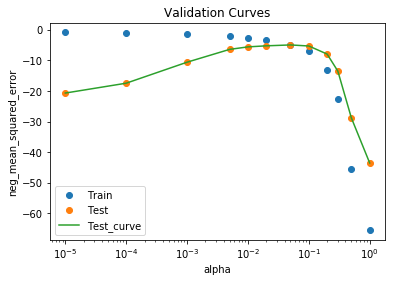

In [53]:
# Lasso 
# Validation Curve
# Scaled Features

scaler=StandardScaler()
X_transformed = scaler.fit_transform(X)

model=linear_model.Lasso(normalize=True)

num_splits=30
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

"""param_search = [
  {'alpha': [0.00001,0.0001,0.001,0.01,0.1,1]}
 ]
"""
#gsrch_rf_model=GridSearchCV(estimator=model, param_grid=param_search, cv=ts_cv, n_jobs=-1)
#gsrch_rf_model.fit(X,y)

#train_sizes, train_scores, test_scores = \
#    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=10), cv=ts_cv, n_jobs=-1)

param_range=[0.00001,0.0001,0.001,0.005,0.01,0.02,0.05,0.1,0.2,0.3,0.5,1]
train_scores_vc, test_scores_vc = \
    validation_curve(estimator=model, X=X_transformed, y=y, param_name="alpha", \
    param_range=param_range, cv=ts_cv, n_jobs=-1, scoring='neg_mean_squared_error')

train_scores_mean = np.mean(train_scores_vc, axis=1)
train_scores_std = np.std(train_scores_vc, axis=1)
test_scores_mean = np.mean(test_scores_vc, axis=1)
test_scores_std = np.std(test_scores_vc, axis=1)

plt.figure()
plt.semilogx(param_range,train_scores_mean,'o',label="Train")
plt.semilogx(param_range,test_scores_mean,'o',label="Test")
plt.semilogx(param_range,test_scores_mean,label="Test_curve")
plt.xlabel("alpha")
plt.ylabel("neg_mean_squared_error")
plt.title("Validation Curves")
plt.legend(loc="best")

In [54]:
scaler=StandardScaler()
X_transformed = scaler.fit_transform(X)

print('alpha=', lasso_best_alpha)
model=linear_model.Lasso(alpha=lasso_best_alpha, normalize=True)
lasso_model.fit(X_transformed, y)  
Y_lasso=lasso_model.predict(X_transformed)

lasso_coef_ = lasso_model.coef_
print(X_cols.shape)
#print(X_cols)
print(lasso_coef_.shape)
print(np.round(lasso_coef_))
#print(lasso_coef_)
X_cols[np.abs(lasso_coef_)>10]

sorted(zip(lasso_coef_, X_cols))

alpha= 0.05
(151,)
(151,)
[-0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. -0.  0.  0.  0. -0. -0. -0. -0.  0. -0. -0. -0. -0.  0.  0. -0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  4.  0.  1.  0.  1.  0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0.  0.  0.  0.  0. -0. -0.  0.  0.  0.  0.
  0.  0. -0.  0.  0.  0. -0. -0.  0.  0.  0.  0.  0. -0. -0. -0.  0. -0.
  0.  0.  0. -0. -0.  0. -0. -0.  0.  0. -0. -0. -0. -0. -0.  0. -0.  0.
 -0.  0. -0.  0. -0. -0.  0.  0.  0. -0. -0.  0.  0.  0. -0.  0. -0. -0.
 -0. -0. -0.  0.  0. -0. -0.  0.  0.  0. -0. -0.  0. -0. -0. -0. -0.  0.
  0.  0.  0.  0. -0.  0.  0.]


[(0.0, 'CAPITAL_OUTLAY_EXPENDITURE'),
 (0.0, 'FEDERAL_REVENUE'),
 (0.0, 'GRADES_12_G'),
 (0.0, 'GRADES_1_8_G'),
 (0.0, 'GRADES_4_G'),
 (0.0, 'GRADES_8_G'),
 (0.0, 'GRADES_9_12_G'),
 (0.0, 'GRADES_ALL_G'),
 (0.0, 'GRADES_KG_G'),
 (0.0, 'GRADES_PK_G'),
 (0.0, 'INSTRUCTION_EXPENDITURE'),
 (0.0, 'LOCAL_REVENUE'),
 (0.0, 'OTHER_EXPENDITURE'),
 (-0.0, 'STATE_ALABAMA'),
 (-0.0, 'STATE_ALASKA'),
 (-0.0, 'STATE_ARIZONA'),
 (-0.0, 'STATE_ARKANSAS'),
 (-0.0, 'STATE_CALIFORNIA'),
 (0.0, 'STATE_COLORADO'),
 (-0.0, 'STATE_CONNECTICUT'),
 (0.0, 'STATE_DELAWARE'),
 (-0.0, 'STATE_DISTRICT_OF_COLUMBIA'),
 (0.0, 'STATE_FLORIDA'),
 (-0.0, 'STATE_GEORGIA'),
 (0.0, 'STATE_HAWAII'),
 (-0.0, 'STATE_IDAHO'),
 (-0.0, 'STATE_ILLINOIS'),
 (0.0, 'STATE_INDIANA'),
 (0.0, 'STATE_IOWA'),
 (0.0, 'STATE_KANSAS'),
 (-0.0, 'STATE_KENTUCKY'),
 (-0.0, 'STATE_LOUISIANA'),
 (0.0, 'STATE_MAINE'),
 (0.0, 'STATE_MARYLAND'),
 (0.0, 'STATE_MASSACHUSETTS'),
 (-0.0, 'STATE_MICHIGAN'),
 (0.0, 'STATE_MINNESOTA'),
 (-0.0, 'STATE_MISSI

Text(0, 0.5, 'y')

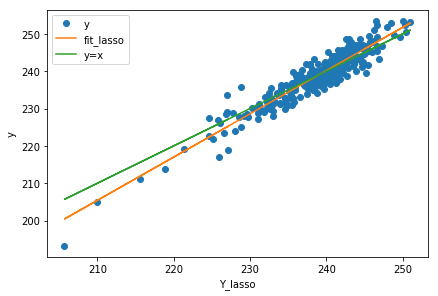

In [55]:
plt.figure(figsize=[15,10])

plt.subplot(2, 2, 1)
plt.plot(Y_lasso,y,'o',Y_lasso,line,Y_lasso,Y_lasso)
plt.legend(("y","fit_lasso","y=x"),loc='best')
plt.xlabel("Y_lasso")
plt.ylabel("y")

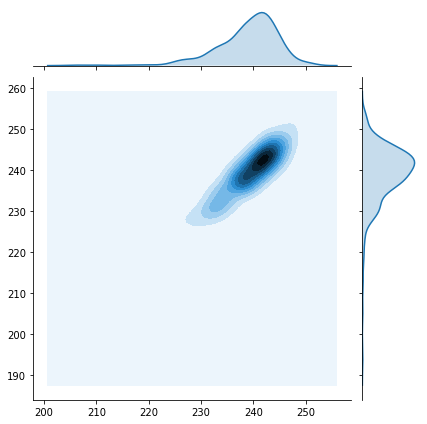

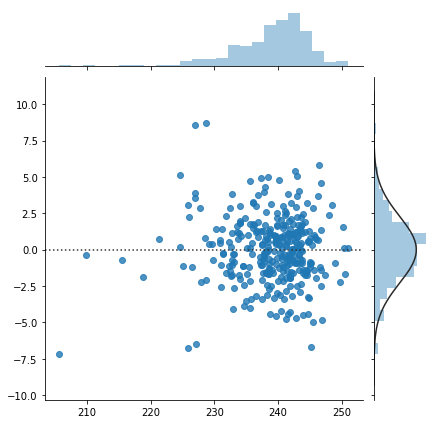

In [56]:
# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(Y_lasso,y)
line = slope*Y_lasso+intercept

#need to make analysis_df that has y,Y_lasso

#Plot
#grid=sns.JointGrid(x=Y_lasso,y=y)
#g=grid.plot_joint(sns.scatterplot) #, hue='smoker'
#sns.scatterplot(Y_lasso,line, ax=g.ax_marg_x, legend=False)
#sns.lmplot(Y_lasso,Y_lasso,ax=g.ax_marg_x,legend=False)

#plt.subplot(1,2,1)
ax1 = sns.jointplot(x=Y_lasso,y=y,kind="kde")
#plt.subplot(1,2,2)
ax2 = sns.jointplot(x=Y_lasso,y=y,kind="resid")

In [57]:
"""
New Features:
-Ratios in commented block (4G/8G, math/reading) w/o bleeding future information etc.
-Elite? financials, location, 
-Good school? school history, tax rev, district
-Trends in time? Deltas in time. more money, more students, higher scores, ...

Further Work: 
-Lasso of PCA features
-Try to predict delta_AVG_MATH_4_SCORE (diff from most recent test score)
--Inference on improving achievement
--One way to deal with intrinsic bias in AVG_MATH_4_SCORE (time-dependence, etc.)
-Try to predict other features
--ENROLL predicts school population. Useful for STATES to know. Can be easily combined with other prediction techniques.



"""

'\nNew Features:\n-Ratios in commented block (4G/8G, math/reading) w/o bleeding future information etc.\n-Elite? financials, location, \n-Good school? school history, tax rev, district\n-Trends in time? Deltas in time. more money, more students, higher scores, ...\n\nFurther Work: \n-Lasso of PCA features\n-Try to predict delta_AVG_MATH_4_SCORE (diff from most recent test score)\n--Inference on improving achievement\n--One way to deal with intrinsic bias in AVG_MATH_4_SCORE (time-dependence, etc.)\n-Try to predict other features\n--ENROLL predicts school population. Useful for STATES to know. Can be easily combined with other prediction techniques.\n\n\n\n'